<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/08_pytorch_paper_replicating_exercise_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Experiment Tracking Exercise Solutions

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.4 MB/s eta 0:00:00
  ERROR: HTTP error 403 while getting https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from https://download.pytorch.org/whl/nightly/cu113/nvidia-cuda-nvrtc-cu12/)
ERROR: Could not install requirement nvidia-cuda-nvrtc-cu12==12.1.105 from https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from torch) because of HTTP error 403 Client Error: Forbidden for url: https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl for URL https

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 41.17 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Скачиваем пиццу, стейки и суши

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

### Подготавливаем данные

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


(<torch.utils.data.dataloader.DataLoader at 0x7f30e0b1f580>,
 ['pizza', 'steak', 'sushi'])

In [7]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

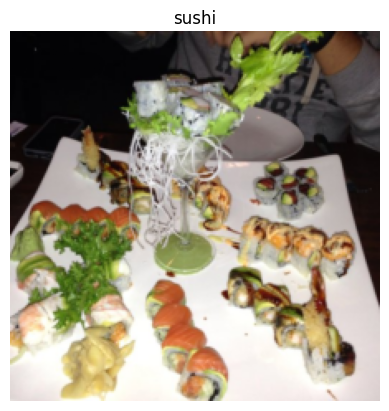

In [8]:
# Строим плот
plt.imshow(image.permute(1, 2, 0)) # переделываем [color_channels, height, width] в [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).


### 1. Делаем слой PatchEmbedding

In [9]:
rand_image_tensor = torch.randn(32, 3, 224, 224) # (batch_size, color_channels, height, width)
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [10]:
# 1. Создаём класс с подклассом nn.Module
class PatchEmbedding(nn.Module):
    # 2. Иниализируем переменные
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Создаем слой для перевода картинок в патчи
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Создаем слой to чтобы свести карты объектов патчей в одномерное измерение
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    # 5. Делаем прямой метод
    def forward(self, x):
        # Тута проверерку делаем, что входные данные имеют правильную форму
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Убедеждаемся, что выходная форма имеет правильный порядок
        return x_flattened.permute(0, 2, 1) # регулируем так, чтобы встраивание было [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [11]:
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)")

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


### 2. TransformerEncoderLayer

In [12]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [13]:
from torchinfo import summary

summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 19.27
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 19.27

### 3. Stack Transformer Encoder Layers on top of each other to make the full Transformer Encoder

In [14]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### 5. Put it all together and create ViT

Пропускаем шаг 4, чтобы его можно было включить в общую архитектуру ViT.

In [15]:
class ViT(nn.Module):
  def __init__(self,
               img_size=224, # из таблицы 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # из таблицы 1
               dropout=0.1,
               mlp_size=3072, # из таблицы 1
               num_transformer_layers=12, # из таблицы 1
               num_heads=12, # из таблицы 1
               num_classes=1000):
    super().__init__()

    # Утверждение: размер изображения должен делиться на размер патча
    assert img_size % patch_size == 0, "Размер изображения должен быть кратен размеру патча."

    # 1. Создать встраивание патчей
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Создать токен класса
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Создать позиционное встраивание
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2 (количество патчей)
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Создать дропаут для встраивания патчей + позиционного встраивания
    self.embedding_dropout = nn.Dropout(p=dropout)

    # 5. Создать стек слоёв кодировщика трансформера (несколько слоёв)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Создать один слой кодировщика трансформера
                                                     num_layers=num_transformer_layers) # Стек слоёв N раз

    # 7. Создать MLP голову
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Получить некоторые размеры из x
    batch_size = x.shape[0]

    # Создать встраивание патчей
    x = self.patch_embedding(x)

    # Сначала расширить токен класса на размер партии
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" означает вычислить размерность

    # Добавить токен класса к встраиванию патчей
    x = torch.cat((class_token, x), dim=1)

    # Добавить позиционное встраивание к встраиванию патчей с токеном класса
    x = self.positional_embedding + x

    # Применить дропаут к встраиванию патчей + позиционному встраиванию
    x = self.embedding_dropout(x)

    # Пропустить встраивание через стек кодировщиков трансформера
    x = self.transformer_encoder(x)

    # Пропустить 0-й индекс x через MLP голову
    x = self.mlp_head(x[:, 0])

    return x


In [16]:
demo_img = torch.randn(1, 3, 224, 224).to(device)
print(demo_img.shape)

# Создаем ViT
vit = ViT(num_classes=len(class_names)).to(device)
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[ 0.1393, -0.2572,  0.1135]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [17]:
summary(model=ViT(num_classes=3),
        input_size=demo_img.shape)

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [18]:
len(class_names)

3

In [19]:
embedding_dim=768
class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                       requires_grad=True)
class_token.requires_grad

True

In [20]:
batch_size = 32
print(class_token.shape)
class_token.expand(batch_size, -1, -1).shape # "-1" means to infer the dimension

torch.Size([1, 1, 768])


torch.Size([32, 1, 768])

In [21]:
patch_size = 16
img_size = 224
num_patches = (img_size*img_size) // patch_size**2
pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
pos_embedding.shape

torch.Size([1, 197, 768])

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.

In [22]:
%%writefile vit.py
import torch
from torch import nn

# 1. Создать класс, который является подклассом nn.Module
class PatchEmbedding(nn.Module):
    # 2. Инициализировать класс с соответствующими переменными
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Создать слой для преобразования изображения в патчи
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Создать слой для выравнивания карт признаков патчей в одномерный вектор
        self.flatten = nn.Flatten(start_dim=2, # выравнивать только размерности карты признаков в один вектор
                                  end_dim=3)

    # 5. Определить метод forward
    def forward(self, x):
        # Создать утверждение для проверки правильности формы входных данных
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Размер входного изображения должен быть кратен размеру патча, форма изображения: {image_resolution}, размер патча: {self.patch_size}"

        # Выполнить прямой проход
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Убедиться, что выходная форма имеет правильный порядок
        return x_flattened.permute(0, 2, 1) # настроить так, чтобы встраивание было на последнем измерении [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

class ViT(nn.Module):
  def __init__(self,
               img_size=224, # из таблицы 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # из таблицы 1
               dropout=0.1,
               mlp_size=3072, # из таблицы 1
               num_transformer_layers=12, # из таблицы 1
               num_heads=12, # из таблицы 1 (количество головок многоголовочного самовнимания)
               num_classes=1000): # общее количество классов (это можно настроить)
    super().__init__()

    # Утверждение: размер изображения должен делиться на размер патча
    assert img_size % patch_size == 0, "Размер изображения должен быть кратен размеру патча."

    # 1. Создать встраивание патчей
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Создать токен класса
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Создать позиционное встраивание
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Создать дропаут для встраивания патчей + позиционного встраивания
    self.embedding_dropout = nn.Dropout(p=dropout)

    # 5. Создать стек слоёв кодировщика трансформера (несколько слоёв)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Создать один слой кодировщика трансформера
                                                     num_layers=num_transformer_layers) # Стек слоёв N раз

    # 7. Создать MLP голову
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Получить некоторые размеры из x
    batch_size = x.shape[0]

    # Создать встраивание патчей
    x = self.patch_embedding(x)
    # print(x.shape)

    # Сначала расширить токен класса на размер партии
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" означает вычислить размерность

    # Добавить токен класса к встраиванию патчей
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Добавить позиционное встраивание к встраиванию патчей с токеном класса
    x = self.positional_embedding + x
    # print(x.shape)

    # Применить дропаут к встраиванию патчей + позиционному встраиванию
    x = self.embedding_dropout(x)

    # Пропустить встраивание через стек кодировщиков трансформера
    x = self.transformer_encoder(x)

    # Пропустить 0-й индекс x через MLP голову
    x = self.mlp_head(x[:, 0])

    return x


Writing vit.py


In [23]:
!python vit.py

In [24]:
from vit import ViT

imported_vit = ViT()
summary(model=imported_vit,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [25]:
set_seeds()

In [26]:
# Создать модель извлекателя признаков ViT
import torchvision

# Загрузить предварительно обученные веса и модель ViT
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" означает лучшие доступные
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

# Заморозить все слои в предварительно обученной модели ViT
for param in pretrained_vit.parameters():
  param.requires_grad = False

# Обновить предварительно обученную голову ViT
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Распечатать сводку
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (размер партии, цветовые каналы, высота, ширина)
        # col_names=["input_size"], # раскомментировать для меньшего вывода
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 150MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [27]:
# Получаем 20% данных
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Настраиваем директории для обучения и тестирования
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # не нужны 20% тестовых данных, так как модель в разделе 7.3 "Отслеживание экспериментов с PyTorch" тестируется на 10% наборе данных, а не на 20%

# Предварительная обработка данных
vit_transforms = vit_weights.transforms() # получаем преобразования из vit_weights
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                           test_dir=test_dir, # используем 10% данных для тестирования
                                                                                           transform=vit_transforms,
                                                                                           batch_size=32)

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [28]:
len(train_dataloader), len(train_dataloader_20_percent), len(test_dataloader)

(8, 15, 3)

In [29]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6443 | train_acc: 0.7521 | test_loss: 0.2314 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.2036 | train_acc: 0.9167 | test_loss: 0.2301 | test_acc: 0.9186
Epoch: 3 | train_loss: 0.1399 | train_acc: 0.9583 | test_loss: 0.1990 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.1000 | train_acc: 0.9688 | test_loss: 0.1778 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.0881 | train_acc: 0.9771 | test_loss: 0.1803 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.0924 | train_acc: 0.9521 | test_loss: 0.1705 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.0655 | train_acc: 0.9812 | test_loss: 0.1785 | test_acc: 0.9583
Epoch: 8 | train_loss: 0.0575 | train_acc: 0.9875 | test_loss: 0.2006 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0657 | train_acc: 0.9938 | test_loss: 0.2046 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0411 | train_acc: 0.9938 | test_loss: 0.1877 | test_acc: 0.9280


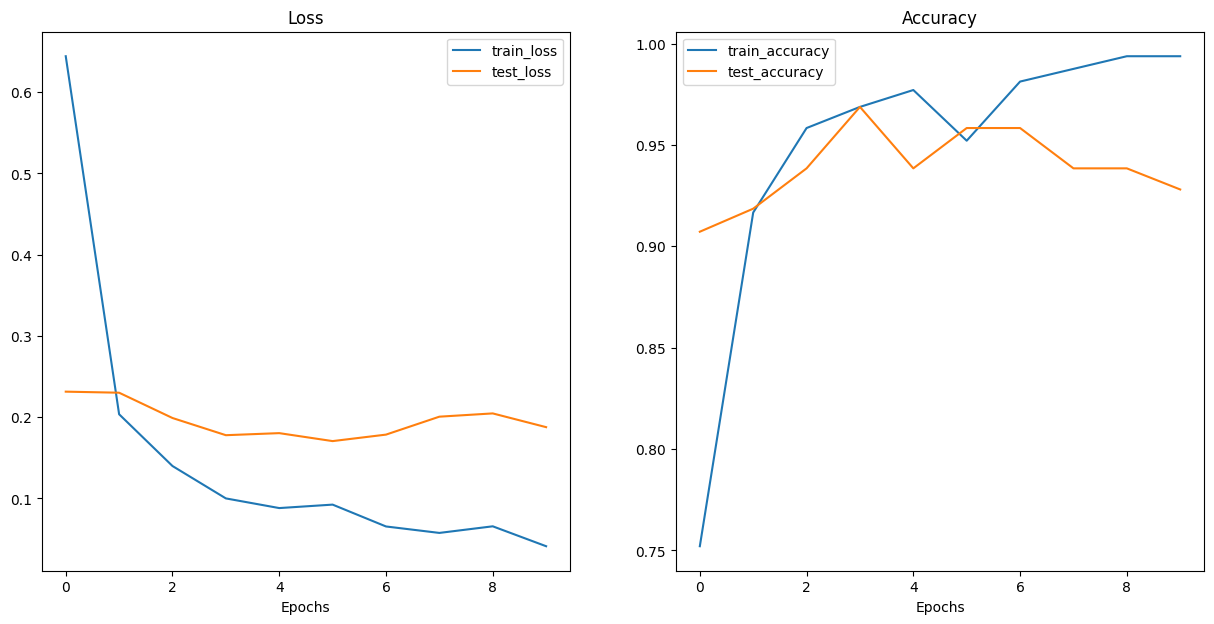

In [30]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [31]:
# Создаем модель извлекателя признаков ViT
import torchvision

# Загружаем предварительно обученные веса и модель ViT
vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # получить веса SWAG
pretrained_vit_swag = torchvision.models.vit_b_16(weights=vit_weights_swag)

# Замораживаем все слои в предварительно обученной модели ViT
for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

# Обновляем предварительно обученную голову ViT
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Делаем сводку
summary(model=pretrained_vit_swag,
        input_size=(1, 3, 384, 384), # (размер партии, цветовые каналы, высота, ширина)
        # col_names=["input_size"], # раскомментировать для меньшего вывода
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:03<00:00, 91.8MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [32]:
# Проверяем преобразования для предварительно обученного ViT с весами SWAG
vit_transforms_swag = vit_weights_swag.transforms() # получаем их из vit_weights_swag
vit_transforms_swag

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [33]:
# Берем 20% данных
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Устанавливаем тренировочные и обучающие директории
train_dir_20_percent = data_20_percent_path / "train"

# Подготовка
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir, # юзаем 10% данных
                                                                                          transform=vit_transforms_swag,
                                                                                          batch_size=32)

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [34]:
# Обучаем предварительно обученный извлекатель признаков ViT с весами SWAG
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=1e-3) # оптимизатор Adam с learning rate 0.001
loss_fn = torch.nn.CrossEntropyLoss() # функция потерь кросс-энтропии

set_seeds() # устанавливаем начальные значения для генератора случайных чисел
pretrained_vit_swag_results = engine.train(model=pretrained_vit_swag,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10, # количество эпох обучения
                                      device=device) # устройство для обучения (CPU или GPU)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4661 | train_acc: 0.9000 | test_loss: 0.0779 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.0641 | train_acc: 0.9854 | test_loss: 0.0619 | test_acc: 0.9896
Epoch: 3 | train_loss: 0.0407 | train_acc: 0.9875 | test_loss: 0.0488 | test_acc: 0.9896
Epoch: 4 | train_loss: 0.0300 | train_acc: 0.9938 | test_loss: 0.0427 | test_acc: 0.9896
Epoch: 5 | train_loss: 0.0241 | train_acc: 0.9938 | test_loss: 0.0435 | test_acc: 0.9896
Epoch: 6 | train_loss: 0.0205 | train_acc: 0.9979 | test_loss: 0.0405 | test_acc: 0.9896
Epoch: 7 | train_loss: 0.0168 | train_acc: 0.9979 | test_loss: 0.0387 | test_acc: 0.9896
Epoch: 8 | train_loss: 0.0197 | train_acc: 0.9979 | test_loss: 0.0396 | test_acc: 0.9896
Epoch: 9 | train_loss: 0.0131 | train_acc: 1.0000 | test_loss: 0.0489 | test_acc: 0.9896
Epoch: 10 | train_loss: 0.0123 | train_acc: 0.9979 | test_loss: 0.0403 | test_acc: 0.9896


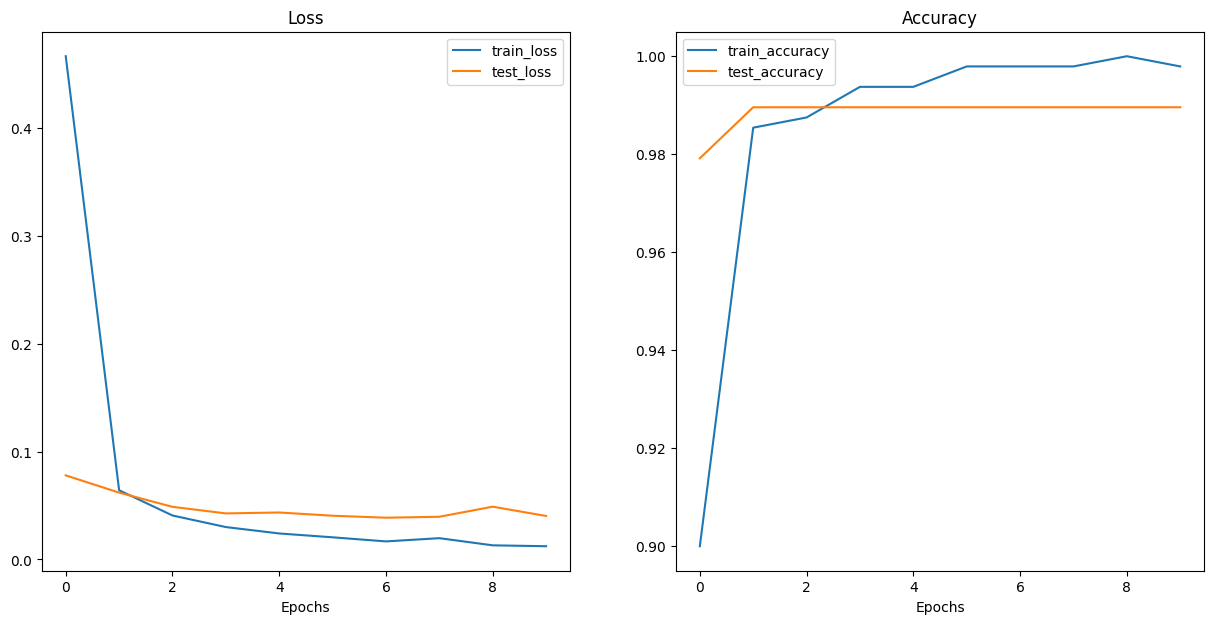

In [35]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_swag_results)

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **Предварительное обучение на ImageNet-21k (больше данных)**: Предварительное обучение на ImageNet-21k, который является более крупным и разнообразным набором данных по сравнению с ImageNet-1K, может значительно улучшить обобщающую способность модели благодаря большему объему и разнообразию данных.
    * **Разогрев скорости обучения (Learning rate warmup)**: Постепенное увеличение скорости обучения в начале тренировки (разогрев) помогает улучшить сходимость, стабильность и обобщающую способность модели, особенно для крупных или сложных моделей.
    * **Уменьшение скорости обучения (Learning rate decay)**: Постепенное уменьшение скорости обучения помогает модели более точно сходиться к локальному минимуму и избегать осцилляции, что улучшает оптимизацию и обобщение.
    * **Обрезка градиентов (Gradient clipping)**: Техника обрезки градиентов используется для предотвращения проблемы взрывающихся градиентов, когда большие градиенты ошибки могут привести к очень большим изменениям весов модели во время обучения, что может вызвать числовую нестабильность.

По сути, это способы для предотвращения переобучение, а в случае предварительной подготовки ImageNet-22k это также помогает предотвратить недостаточное обучение.